# BAPOSGMCP Analysis for Single Environment

In this file we do an analysis of BAPOSGMCP for policies trained in a single environment but using different seeds and/or training algorithms.

We look at:

- Same-play
- Cross-play between policies trained with the same algorithm but different seeds
- Cross-play between policies trained with different algorithms


## Notation

- **Same-play** refers to pairings of policies that are trained together or atleast trained as part of the same population
- **Cross-play** refers to pairings of policies that were not trained together

In [1]:
import os.path as osp
from typing import List, Any, Optional, Tuple
from itertools import permutations, product

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import posggym

import exp_utils
import plot_utils

# Data Loading

Firstly lets load the data and do a little cleaning and setup by:

1. removing unused columns
2. add columns for agent policy training environment and reasoning level

## BAPOSGMCP Data

Next we load the BAPOSGMCP experiment data.

In [6]:
ba_results_dir_name = 'baposgmcp_exp_2949'

ba_columns_to_drop = [
    "Unnamed: 0",
    'Unnamed: 0.1',
    'Unnamed: 0.2', 
    "args",
    "episode_step_limit",
    "time_limit",
    "use_checkpointing",
    "reinvigoration_time_mean",
    "reinvigoration_time_std",
    "inference_time_mean",
    "inference_time_std",
    "policy_calls_mean",
    "policy_calls_std",
#     "search_time_mean",
#     "search_time_std",
#     "update_time_mean",
#     "update_time_std",
    "episode_returns_mean",
    "episode_returns_std",
    "episode_returns_max",
    "episode_returns_min",
    "episode_discounted_returns_max",
    "episode_discounted_returns_min",
    "episode_dones",
]

ba_df = plot_utils.import_results(ba_results_dir_name, ba_columns_to_drop, True)

print("Columns:\n", ba_df.columns, "\n")
plot_utils.validate_and_display(ba_df, True)

Columns:
 Index(['exp_id', 'agent_id', 'env_name', 'seed', 'num_episodes', 'policy_name',
       'other_policy_prior', 'num_sims', 'c_init', 'c_base',
       ...
       'coplayer_K', 'coplayer_train_seed', 'rollout_id', 'rollout_K',
       'rollout_seed', 'rollout_alg', 'other_alg', 'other_seed',
       'coplayer_num_sims', 'coplayer_other_seed'],
      dtype='object', length=415) 

Agent IDs: [0 1]
Test Env: Driving7x7RoundAbout-v0
Seeds: [0 1 2 3 4 5 6 7 8 9]
Policy K: ['2' 'BA']
Policy Names: ['BAPOSGMCP_0' 'PPOPolicy_pi_2']
Coplayer Policy K: ['2' 'BA']
Coplayer Train Seed: [2 'None' 0 1 4 3]
Num rows/entries: 800
Num experiments: 400

BAPOSGMCP Hyperparameters
Num sims: ['1024' '128' '16' '256' '32' '512' '64' '8']
Rollout Policy K: ['BR']
Rollout Policy IDs: ['pi_BR']
Rollout Policy Seeds: [0]
Rollout Policy Algs: ['klr']
Other Agent Policy Algs: ['klr']
Other Agent Policy Seeds: [0]
other_policy_prior: None
truncated: True
c_init: 1.0
c_base: 100.0
reinvigorator: <baposgmcp.tree

## RL policies

First we load the data from the RL policies only experiments. This is used as a baseline for comparing against.

In [10]:
rl_results_dir = 'pairwise_comparison_initseed0_numseeds1_2022-07-11_22-53-01l5ob5c1v'

columns_to_drop = [
    'Unnamed: 0', 
    'episode_step_limit', 
    'time_limit', 
    'use_checkpointing',
    'search_time_mean', 
    'search_time_std', 
    'update_time_mean', 
    'update_time_std',
    'reinvigoration_time_mean', 
    'reinvigoration_time_std', 
    'policy_calls_mean', 
    'policy_calls_std', 
    'inference_time_mean', 
    'inference_time_std',
    'episode_dones',
]
rl_df = plot_utils.import_results(rl_results_dir, columns_to_drop, False)

rl_df = rl_df[
    rl_df["exp_id"].isin(
        rl_df[
            (rl_df["K"].isin(ba_df["rollout_K"]))
            & (rl_df["train_seed"].isin(ba_df["rollout_seed"]))
            & (rl_df["coplayer_K"].isin(ba_df["coplayer_K"]))
        ]["exp_id"]
    )
]

rl_df.columns
plot_utils.validate_and_display(rl_df, False)
rl_df

Agent IDs: [0 1]
Test Env: Driving7x7RoundAbout-v0
Seeds: [0]
Policy K: ['2' 'BR']
Policy Names: ['PPOPolicy_pi_2' 'PPOPolicy_pi_BR']
Train Envs:: ['Driving7x7RoundAbout-v0']
Train Seeds: [0 1 2 3 4]
Train Algorithms: ['klr']
Coplayer Policy K: ['2' 'BR']
Coplayer Train Seed: [0 1 2 3 4]
Num rows/entries: 12
Num experiments: 6


,exp_id,agent_id,env_name,seed,num_episodes,policy_name,policy_dir,policy_id,eval_mode,episode_returns_mean,...,prop_LOSS,prop_DRAW,prop_WIN,prop_NA,K,train_env_name,train_seed,train_alg,coplayer_K,coplayer_train_seed
486,241,0,Driving7x7RoundAbout-v0,0,1000,PPOPolicy_pi_BR,train_klr_Driving7x7RoundAbout-v0_k4_seed0_202...,pi_BR,True,0.992,...,0.004,0.0,0.996,0.000,BR,Driving7x7RoundAbout-v0,0,klr,2,4
487,241,1,Driving7x7RoundAbout-v0,0,1000,PPOPolicy_pi_2,train_klr_Driving7x7RoundAbout-v0_k4_seed4_202...,pi_2,True,0.992,...,0.004,0.0,0.996,0.000,2,Driving7x7RoundAbout-v0,4,klr,BR,0
780,192,0,Driving7x7RoundAbout-v0,0,1000,PPOPolicy_pi_BR,train_klr_Driving7x7RoundAbout-v0_k4_seed0_202...,pi_BR,True,1.000,...,0.000,0.0,1.000,0.000,BR,Driving7x7RoundAbout-v0,0,klr,2,3
781,192,1,Driving7x7RoundAbout-v0,0,1000,PPOPolicy_pi_2,train_klr_Driving7x7RoundAbout-v0_k4_seed3_202...,pi_2,True,1.000,...,0.000,0.0,1.000,0.000,2,Driving7x7RoundAbout-v0,3,klr,BR,0
792,143,0,Driving7x7RoundAbout-v0,0,1000,PPOPolicy_pi_BR,train_klr_Driving7x7RoundAbout-v0_k4_seed0_202...,pi_BR,True,0.986,...,0.007,0.0,0.993,0.000,BR,Driving7x7RoundAbout-v0,0,klr,2,2
793,143,1,Driving7x7RoundAbout-v0,0,1000,PPOPolicy_pi_2,train_klr_Driving7x7RoundAbout-v0_k4_seed2_202...,pi_2,True,0.986,...,0.007,0.0,0.993,0.000,2,Driving7x7RoundAbout-v0,2,klr,BR,0
1030,45,0,Driving7x7RoundAbout-v0,0,1000,PPOPolicy_pi_BR,train_klr_Driving7x7RoundAbout-v0_k4_seed0_202...,pi_BR,True,0.982,...,0.009,0.0,0.991,0.000,BR,Driving7x7RoundAbout-v0,0,klr,2,0
1031,45,1,Driving7x7RoundAbout-v0,0,1000,PPOPolicy_pi_2,train_klr_Driving7x7RoundAbout-v0_k4_seed0_202...,pi_2,True,0.976,...,0.009,0.0,0.985,0.006,2,Driving7x7RoundAbout-v0,0,klr,BR,0
1038,94,0,Driving7x7RoundAbout-v0,0,1000,PPOPolicy_pi_BR,train_klr_Driving7x7RoundAbout-v0_k4_seed0_202...,pi_BR,True,1.000,...,0.000,0.0,1.000,0.000,BR,Driving7x7RoundAbout-v0,0,klr,2,1
1039,94,1,Driving7x7RoundAbout-v0,0,1000,PPOPolicy_pi_2,train_klr_Driving7x7RoundAbout-v0_k4_seed1_202...,pi_2,True,1.000,...,0.000,0.0,1.000,0.000,2,Driving7x7RoundAbout-v0,1,klr,BR,0


# The environment

Here we can see the layout for the environment. Noting that the start and destination positions for each agent changes each episode. Agents always start in a cell along the bottom or right side of the grid and have a destination in a cell along the top or left side of the grid.  

Agents can observe a rectangular area around their current location that that contains 3 cells in front, 1 behind and 1 cell to each side (total 4x3=12 cells), shown by the highlighted cells in the images. 

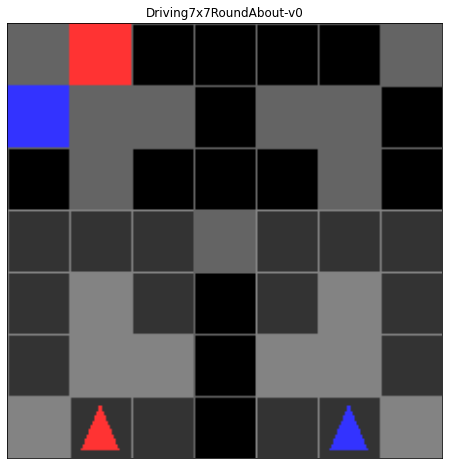

In [12]:
plot_utils.plot_environment(ba_df["env_name"].unique()[0])    
plt.show()

### Helper functions

The next few code blocks contain functions for plotting and cleaning data.

In [13]:
def get_all_mean_rl_pw_values(plot_df, y_key: str):
    row_policy_IDs = plot_df["K"].unique().tolist()
    row_policy_IDs.sort()
    col_policy_IDs = plot_df["coplayer_K"].unique().tolist()
    col_policy_IDs.sort()
    
    xp_pw_returns = np.zeros((len(row_policy_IDs), len(col_policy_IDs)))
    sp_pw_returns = np.zeros((len(row_policy_IDs), len(col_policy_IDs)))

    for r, row_policy_id in enumerate(row_policy_IDs):
        for c, col_policy_id in enumerate(col_policy_IDs):
            sp_return, xp_return = plot_utils.get_mean_pairwise_values(
                plot_df,
                row_conds=[("K", "==", row_policy_id)],
                row_seed_key="train_seed",
                row_alg_key="train_alg",
                col_conds=[("K", "==", col_policy_id)],
                col_seed_key="train_seed",
                col_alg_key="train_alg",
                y_key=y_key
            )

            sp_pw_returns[r][c] = sp_return
            xp_pw_returns[r][c] = xp_return
    
    return (row_policy_IDs, col_policy_IDs), sp_pw_returns, xp_pw_returns

def get_all_mean_ba_pw_values(plot_df, y_key: str):
    """Get pairwise mean values for num_sims vs coplayer policy.
    
    This will be for a specific rollout policy.
    """
    ba_only_plot_df = plot_utils.filter_by(plot_df, [("K", "==", "BA")])
    assert len(ba_only_plot_df["rollout_K"].unique().tolist()) == 1

    num_sims = ba_only_plot_df["num_sims"].unique().tolist()
    num_sims = [int(n) for n in num_sims]
    num_sims.sort()
    print(f"{num_sims=}")

    ba_coplayer_df = plot_df[plot_df["K"] != "BA"]
    coplayer_K = ba_coplayer_df["K"].unique().tolist()
    coplayer_K.sort()
    print(f"{coplayer_K=}")
    
    xp_pw_returns = np.zeros((len(num_sims), len(coplayer_K)))
    sp_pw_returns = np.zeros((len(num_sims), len(coplayer_K)))

    for r, r_num_sims in enumerate(num_sims):
        for c, cp_K in enumerate(coplayer_K):
            rc_plot_df = plot_utils.filter_exps_by(plot_df, [("K", "==", "BA"), ("num_sims", "==", str(r_num_sims))])
            rc_plot_df = plot_utils.filter_exps_by(rc_plot_df, [("K", "==", cp_K)])
            
            # Checks
            ba_only_df = rc_plot_df[rc_plot_df["K"] == "BA"]
            assert len(ba_only_df["num_sims"].unique()) <= 1
            if len(ba_only_df["num_sims"].unique()) == 0:
                print(f"Missing data for {r=} {r_num_sims=} {c=} {cp_K=}")
                continue
            
            cp_only_df = rc_plot_df[rc_plot_df["K"] != "BA"]
            assert len(cp_only_df["K"].unique()) == 1
            
            sp_return, xp_return = plot_utils.get_mean_pairwise_values(
                rc_plot_df,
                row_conds=[("K", "==", "BA")],
                row_seed_key="rollout_seed",
                row_alg_key="rollout_alg",
                col_conds=[("K", "!=", "BA")],
                col_seed_key="train_seed",
                col_alg_key="train_alg",
                y_key=y_key
            )

            sp_pw_returns[r][c] = sp_return
            xp_pw_returns[r][c] = xp_return
    
    return (num_sims, coplayer_K), sp_pw_returns, xp_pw_returns


In [24]:
def lineplot_ba_values_by_rollout_K(plot_df, 
                                    y_key: str, 
                                    y_err_key: str,
                                    include_rl_comparison: bool, 
                                    plot_rl_df: Optional,
                                    vrange: Optional[Tuple[float, float]] = None,
                                    figsize: Optional[Tuple[int, int]] = None,
                                    save_fig: bool = False):
    """Plot different BA rollout policies self-play and cross-play values against 
    num sims for different for the different co-player policies
    """
    ba_only_df = plot_df[plot_df["K"] == "BA"]
    rollout_Ks = ba_only_df["rollout_K"].unique().tolist()
    rollout_Ks.sort()
    print(f"{rollout_Ks=}")
    
    coplayer_Ks = ba_only_df["coplayer_K"].unique().tolist()
    
    rl_Ks = []
    if include_rl_comparison:
        rl_Ks = plot_rl_df["K"].unique()
        rl_Ks.sort()
    
    ncols = len(coplayer_Ks)
    nrows = len(rollout_Ks)
    if figsize is None:
        figsize = (14, 2+nrows*4)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, squeeze=False)
    
    for row, rollout_K in enumerate(rollout_Ks):
        print(f"{row=} {rollout_K=}")
        ba_df_r_k = plot_utils.filter_exps_by(ba_df, [("K", "==", "BA"), ("rollout_K", "==", rollout_K)])
        (row_num_sims, row_cp_Ks), row_sp_values, row_xp_values = get_all_mean_ba_pw_values(ba_df_r_k, y_key=y_key)
        _, row_sp_errs, row_xp_errs = get_all_mean_ba_pw_values(ba_df_r_k, y_key=y_err_key)
        
        add_rl_comparison = include_rl_comparison and rollout_K in rl_Ks
        if add_rl_comparison and rollout_K in rl_Ks:
            rollout_K_rl_df = plot_utils.filter_exps_by(plot_rl_df, [("K", "==", rollout_K)])
            
            (rollout_K_rl_Ks, rollout_K_rl_cp_Ks), rl_sp_values, rl_xp_values = get_all_mean_rl_pw_values(
                rollout_K_rl_df, y_key
            )
            _, rl_sp_err_values, rl_xp_err_values = get_all_mean_rl_pw_values(
                rollout_K_rl_df, y_err_key
            )
            
            rollout_K_idx = rollout_K_rl_Ks.index(rollout_K)
            
            rollout_K_sp_values = np.zeros(len(row_cp_Ks))
            rollout_K_xp_values = np.zeros(len(row_cp_Ks))
            rollout_K_sp_err_values = np.zeros(len(row_cp_Ks))
            rollout_K_xp_err_values = np.zeros(len(row_cp_Ks))
            
            for i, cp_K in enumerate(row_cp_Ks):
                if cp_K in rollout_K_rl_cp_Ks:
                    cp_idx = rollout_K_rl_cp_Ks.index(cp_K)
                    rl_sp_v = rl_sp_values[rollout_K_idx][cp_idx]
                    rl_xp_v = rl_xp_values[rollout_K_idx][cp_idx]
                    rl_sp_err_v = rl_sp_err_values[rollout_K_idx][cp_idx]
                    rl_xp_err_v = rl_xp_err_values[rollout_K_idx][cp_idx]
                else:
                    rl_sp_v, rl_xp_v, rl_sp_err_v, rl_xp_err_v = np.nan, np.nan, np.nan, np.nan

                rollout_K_sp_values[i] = rl_sp_v
                rollout_K_xp_values[i] = rl_xp_v
                rollout_K_sp_err_values[i] = rl_sp_err_v
                rollout_K_xp_err_values[i] = rl_xp_err_v
        
        if vrange is None:
            min_value = np.nanmin([
                np.nanmin(row_sp_values - row_sp_errs), 
                np.nanmin(row_xp_values - row_xp_errs)
            ])
            max_value = np.nanmax([
                np.nanmax(row_sp_values + row_sp_errs), 
                np.nanmax(row_xp_values + row_xp_errs)
            ])
            vrange = (min_value - (min_value*0.05), max_value + (max_value*0.05))
        
        for i, cp_K in enumerate(coplayer_Ks):
            print(f"  {i=} {cp_K=}")
            ax = axs[row][i]
            
            # Add XP first since always present
            xp_ys = row_xp_values[:, i]
            xp_errs = row_xp_errs[:, i]
            ax.errorbar(row_num_sims, xp_ys, yerr=xp_errs, label="XP-BA")
            
            if add_rl_comparison:
                rl_i_xp_ys = [rollout_K_xp_values[i]] * len(row_num_sims)
                rl_i_xp_errs = [rollout_K_xp_err_values[i]] * len(row_num_sims)
                ax.errorbar(row_num_sims, rl_i_xp_ys, yerr=rl_i_xp_errs, label="XP-RO")
            
            # Add SP second since it may not be present for some cp_K
            sp_ys = row_sp_values[:, i]
            if not np.isnan(np.sum(sp_ys)):
                sp_errs = row_sp_errs[:, i]
                ax.errorbar(row_num_sims, sp_ys, yerr=sp_errs, label="SP-BA")
            
                if add_rl_comparison:
                    rl_i_sp_ys = [rollout_K_sp_values[i]] * len(row_num_sims)
                    rl_i_sp_errs = [rollout_K_sp_err_values[i]] * len(row_num_sims)
                    ax.errorbar(row_num_sims, rl_i_sp_ys, yerr=rl_i_sp_errs, label="SP-RO")
            
            ax.set_xlabel("Num simulations")
            ax.set_title(cp_K)
            ax.set_ylim(vrange)
            ax.legend()

        axs[row][0].set_ylabel(f"{rollout_K}")
    
    fig.suptitle(y_key)
    fig.tight_layout()
    if save_fig:
        fig.savefig(osp.join(exp_utils.EXP_BASE_DIR, "figures", f"{y_key}.png"))

In [15]:
def plot_ba_values_by_rollout_K(plot_df, 
                                y_key: str, 
                                include_rl_comparison: bool, 
                                plot_rl_df: Optional,
                                vrange: Optional[Tuple[float, float]] = None,
                                figsize: Optional[Tuple[int, int]] = None):
    """Plot self-play and cross-play values against num sims for different 
    BA rollout policies.
    """
    ba_only_df = plot_df[plot_df["K"] == "BA"]
    rollout_Ks = ba_only_df["rollout_K"].unique().tolist()
    rollout_Ks.sort()
    print(f"{rollout_Ks=}")
    
    coplayer_Ks = ba_only_df["coplayer_K"].unique().tolist()
    coplayer_Ks.sort()
    print(f"{coplayer_Ks=}")
    
    ncols = 2
    nrows = len(rollout_Ks)
    if figsize is None:
        figsize = (ncols*4, nrows*3)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, squeeze=False)
    
    rl_Ks = []
    if include_rl_comparison:
        rl_Ks = plot_rl_df["K"].unique()
        rl_Ks.sort()
        print(f"{rl_Ks=}")
    
    for row, rollout_K in enumerate(rollout_Ks):
        print(f"{row=} {rollout_K=}")
        ba_df_r_k = plot_utils.filter_exps_by(plot_df, [("K", "==", "BA"), ("rollout_K", "==", rollout_K)])
        (row_num_sims, row_cp_Ks), row_sp_values, row_xp_values = get_all_mean_ba_pw_values(
            ba_df_r_k, y_key=y_key
        )

        row_labels = row_num_sims
        col_labels = row_cp_Ks
        
        if include_rl_comparison and rollout_K in rl_Ks:
            # add performance of Rollout policy to the table
            rollout_K_rl_df = plot_utils.filter_exps_by(plot_rl_df, [("K", "==", rollout_K)])
            (rollout_K_rl_Ks, rollout_K_rl_cp_Ks), rl_sp_values, rl_xp_values = get_all_mean_rl_pw_values(
                rollout_K_rl_df, y_key
            )
            
            rollout_K_idx = rollout_K_rl_Ks.index(rollout_K)
            
            rollout_K_sp_values = np.zeros(len(row_cp_Ks))
            rollout_K_xp_values = np.zeros(len(row_cp_Ks))
            
            for i, cp_K in enumerate(row_cp_Ks):
                if cp_K in rollout_K_rl_cp_Ks:
                    cp_idx = rollout_K_rl_cp_Ks.index(cp_K)
                    rl_sp_v = rl_sp_values[rollout_K_idx][cp_idx]
                    rl_xp_v = rl_xp_values[rollout_K_idx][cp_idx]
                else:
                    rl_sp_v = np.nan
                    rl_xp_v = np.nan    
                rollout_K_sp_values[i] = rl_sp_v
                rollout_K_xp_values[i] = rl_xp_v

            row_sp_values = np.vstack([row_sp_values, rollout_K_sp_values])
            row_xp_values = np.vstack([row_xp_values, rollout_K_xp_values])
            row_labels.append(rollout_K)
        
        if vrange is None:
            min_value = np.nanmin([np.nanmin(row_sp_values), np.nanmin(row_xp_values)])
            max_value = np.nanmax([np.nanmax(row_sp_values), np.nanmax(row_xp_values)])
            vrange = (min_value, max_value)

        plot_utils.plot_pairwise_heatmap(axs[row][0], (row_labels, col_labels), row_sp_values, title=f"Same-Play", vrange=vrange)
        plot_utils.plot_pairwise_heatmap(axs[row][1], (row_labels, col_labels), row_xp_values, title=f"Cross-Play", vrange=vrange)

        axs[row][0].set_ylabel(f"{rollout_K}")

    fig.tight_layout()
    fig.suptitle(y_key)
    

## BAPOSGMCP analysis dimensions

There are multiple dimensions of variation for BAPOSGMCP experiments:

1. `num sims` - the number of simulations used by BAPOSGMCP for search per real step.
2. `rollout policy K/ID` and `other agent policies alg` (this are correlated so we group them together):
   - The rollout policy used by BAPOSGMCP, can be either `BR` (KLR Best response) or `SP` (self-play)
   - The set of policies used by BAPOSGMCP to represent the other agent during search
3. `rollout policy seed` and `other agent policies seed` (again correlated, so group together)
   - The training seed for the rollout and other agent policies - i.e. the training population of the policies used by BAPOSGMCP.

Note, here `other agent` refers to the set of policies used by BAPOSGMCP to represent the other agents (i.e. the set of policies BAPOSGMCP assumes the real other agent is playing a policy from). This is seperate from the actual opponent/co-player policy used in each experiment run. For some experiment runs the actual opponent/co-player policy will be one of the policies from the `other agent` policy set being used by BAPOSGMCP. For other experiments the actual co-player policy will be from outside the set used by BAPOSGMCP, in this case the co-player policy will be from a population using a different seed and/or training algorithm. 

What we want to know is the average performance of BAPOSGMCP for each `rollout policy K/ID`/`other agent policies alg` for the different `num sims`. Here we take the average over `rollout policy/other agent policies seed`. So lets do that :)

# BAPOSGMCP Analysis Part 2

A weakness of the previous experiments was the low sample size for BAPOSGMCP since only 100 episodes were run for each experiment.

To take a deeper dive into trying to understand the results we ran the same experiments except with a few key differences:

1. Ran for 1000 episodes (by doing 10 runs of 100 episodes using different seeds)
2. Also recorded accuracy of BAPOSGMCPs belief about the other agent's actions and their history. Also tracked accuracy about belief over states.
3. Only ran against a single other agent policy "pi_2" and only for the klr prior.

## Averaging data over seeds

First step is to collate all the different seeds of the same experiment parameters.

In [21]:
group_keys = [
    "agent_id", 
    "K",
    "num_sims", 
    "coplayer_K",
    "coplayer_train_seed",
    "coplayer_num_sims",
    "coplayer_other_seed",
    "train_seed", 
    "train_alg",
    "rollout_K", 
    "rollout_seed",
    "rollout_alg",
    "other_alg",
    "other_seed"
]

groups = ba_df.groupby(group_keys)

new_df = groups["episode_discounted_returns_mean"].mean().reset_index()
new_df["exp_id"] = groups["exp_id"].min().reset_index()["exp_id"]
new_df["num_episodes"] = groups["num_episodes"].sum().reset_index()["num_episodes"]

new_df.sort_values(["agent_id", "num_sims"], inplace=True)

print(new_df)
print(new_df["K"].unique())

# Number of expected entries
# 10 experiment seeds
# BAPOSGMCP: 1 other_prior seeds * 8 num_sims
# pi_2: 5 train_seeds
# Total entries = 2 * (10 * 1 * 8 * 5) = 800
# Averaged entries = 800 / 10 = 80

    agent_id   K num_sims coplayer_K coplayer_train_seed coplayer_num_sims  \
0          0  BA     1024          2                   0              None   
1          0  BA     1024          2                   1              None   
2          0  BA     1024          2                   2              None   
3          0  BA     1024          2                   3              None   
4          0  BA     1024          2                   4              None   
..       ...  ..      ...        ...                 ...               ...   
75         1   2     None         BA                None                 8   
76         1   2     None         BA                None                 8   
77         1   2     None         BA                None                 8   
78         1   2     None         BA                None                 8   
79         1   2     None         BA                None                 8   

   coplayer_other_seed train_seed train_alg rollout_K rollout_s

rollout_Ks=['BR']
coplayer_Ks=['2']
rl_Ks=array(['2', 'BR'], dtype=object)
row=0 rollout_K='BR'
num_sims=[8, 16, 32, 64, 128, 256, 512, 1024]
coplayer_K=['2']


/home/jonathon/miniconda3/envs/ba-posgmcp/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jonathon/miniconda3/envs/ba-posgmcp/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


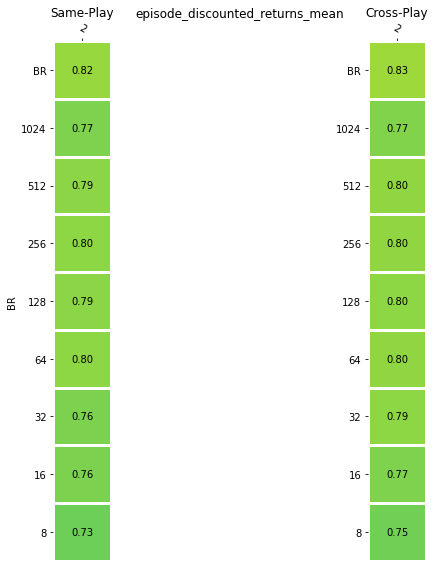

In [18]:
plot_ba_values_by_rollout_K(
    new_df, 
    y_key="episode_discounted_returns_mean", 
    include_rl_comparison=True, 
    plot_rl_df=rl_df,
    vrange=(-0.2, 1.0),
    figsize=(12, 8)
)
plt.show()

# BR RL (seed=0) vs pi_2
# Same play = 0.82
# Cross play = 0.82

# Need to get same rollout K seed

rollout_Ks=['BR']
coplayer_Ks=['2']
row=0 rollout_K='BR'
num_sims=[8, 16, 32, 64, 128, 256, 512, 1024]
coplayer_K=['2']


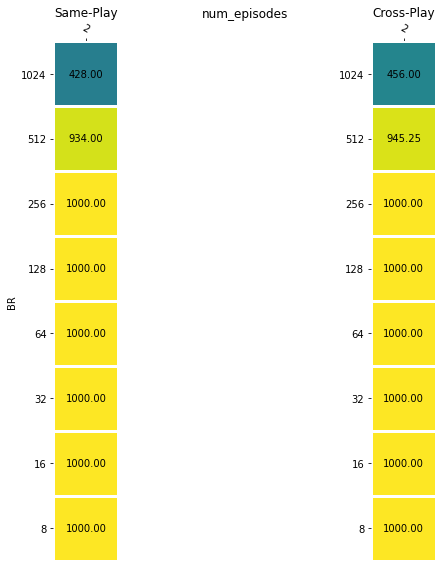

In [19]:
plot_ba_values_by_rollout_K(
    new_df, 
    y_key="num_episodes", 
    include_rl_comparison=False, 
    plot_rl_df=rl_df,
    vrange=(0, 1000),
    figsize=(12, 8)
)
plt.show()

rollout_Ks=['BR']
row=0 rollout_K='BR'
num_sims=[8, 16, 32, 64, 128, 256, 512, 1024]
coplayer_K=['2']
num_sims=[8, 16, 32, 64, 128, 256, 512, 1024]
coplayer_K=['2']
  i=0 cp_K='2'


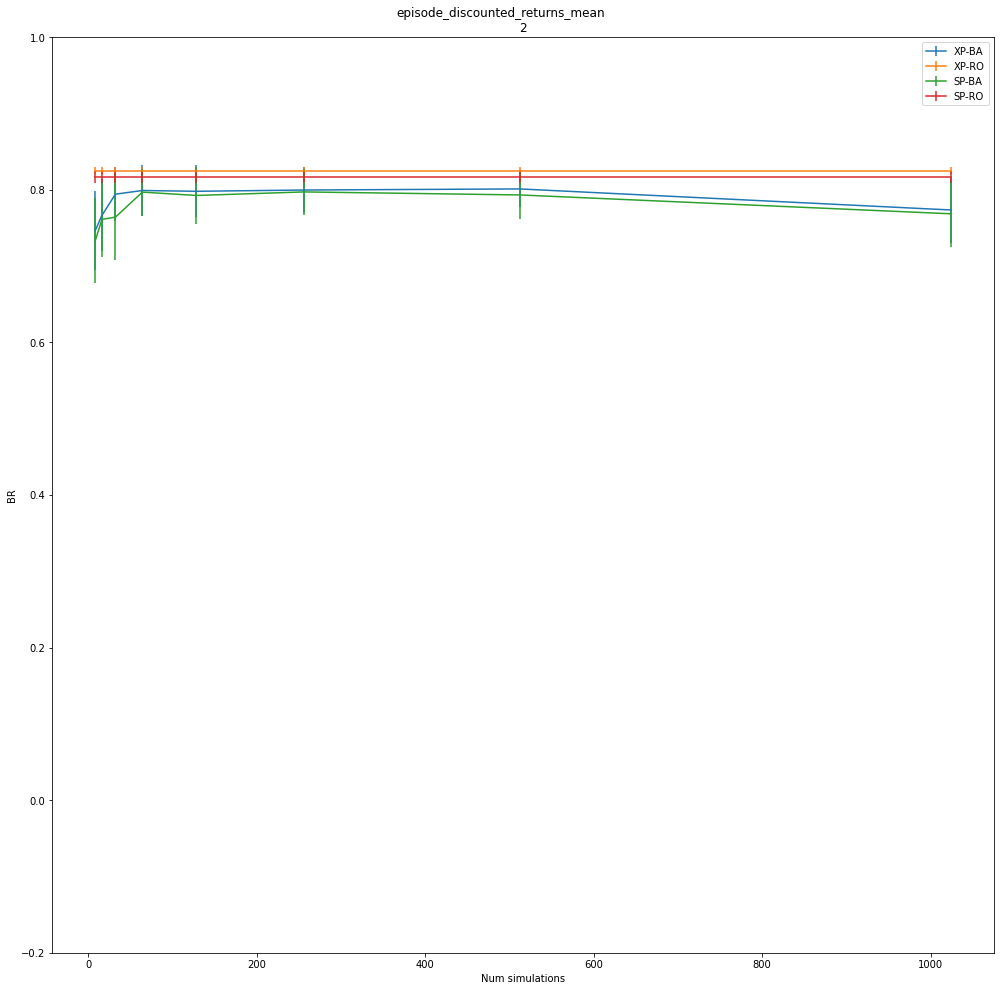

In [25]:
lineplot_ba_values_by_rollout_K(
    new_df, 
    y_key="episode_discounted_returns_mean",
    y_err_key="episode_discounted_returns_CI",
    include_rl_comparison=True, 
    plot_rl_df=rl_df,
    vrange=(-0.2, 1.0),
    figsize=(14, 14)
)
plt.show()